In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os
import pickle

from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt
import scipy

import cx_rate
import trials
import plotter
import bee_simulator

from cx_spiking.central_complex import CX_SPIKING
from cx_spiking.constants import *
import cx_spiking 

In [2]:
routes_path = os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/experiments/routes/')

experiments_path = os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/experiments/vonmises_vs_cosine/experiments/')

T_outbound = 1500
T_inbound = 1500

In [3]:
def extract_angles(bee_coords):
    diffs = np.diff(bee_coords, axis=0)
    h = np.arctan2(diffs[:,0], diffs[:,1])
    return h

def absolute_angle_diff(angle1, angle2):
    diff = np.fmod((angle1 - angle2) + np.pi * 3, 2 * np.pi) - np.pi
    return np.abs(diff)

def angle_diff(angle1, angle2):
    return np.fmod((angle1 - angle2) + np.pi * 3, 2 * np.pi) - np.pi

In [71]:
# def plot_results(cpu4_method):
vm_means = []
cos_means = []
vm_cos_means = []

vm_abs_means = []
cos_abs_means = []
vm_cos_abs_means = []

vm_results = []
cos_results = []
vm_cos_results = []

vm_abs_results = []
cos_abs_results = []
vm_cos_abs_sresults = []

hs = []
vm_bee_coords = []
cos_bee_coords = []

for cpu4_method in [1,2]:
    for exp in range(100):
        with open(os.path.join(routes_path, f'route_{exp}.pickle'), 'rb') as fh:
            data = pickle.load(fh)

        h = data['h']
        v = data['v']
        cx_log = data['cx_log']

        with open(os.path.join(experiments_path, f'exp_{exp}_cpu4_{cpu4_method}.pickle'), 'rb') as fh:
            data = pickle.load(fh)

        spiking_cx_vm = data['spiking_cx_vm']
        spiking_cx_cos = data['spiking_cx_cos']

        h_vm = spiking_cx_vm['heading_angles']
        h_cos = spiking_cx_cos['heading_angles']
        
        
        hs.append(h)
        vm_bee_coords.append(spiking_cx_vm['bee_coords'])
        cos_bee_coords.append(spiking_cx_cos['bee_coords'])



        # Store all trips
        vm_results.append(angle_diff(h[:T_outbound], h_vm[:T_outbound]))
        cos_results.append(angle_diff(h[:T_outbound], h_cos[:T_outbound]))
        vm_cos_results.append(angle_diff(h_vm[:T_outbound], h_cos[:T_outbound]))

        vm_abs_results.append(absolute_angle_diff(h[:T_outbound], h_vm[:T_outbound]))
        cos_abs_results.append(absolute_angle_diff(h[:T_outbound], h_cos[:T_outbound]))
        vm_cos_abs_sresults.append(absolute_angle_diff(h_vm[:T_outbound], h_cos[:T_outbound]))

        # Store means for each trip
        vm_means.append(np.mean(angle_diff(h[:T_outbound], h_vm[:T_outbound])))
        cos_means.append(np.mean(angle_diff(h[:T_outbound], h_cos[:T_outbound])))
        vm_cos_means.append(np.mean(angle_diff(h_vm[:T_outbound], h_cos[:T_outbound]))) 

        vm_abs_means.append(np.mean(absolute_angle_diff(h[:T_outbound], h_vm[:T_outbound])))
        cos_abs_means.append(np.mean(absolute_angle_diff(h[:T_outbound], h_cos[:T_outbound])))
        vm_cos_abs_means.append(np.mean(absolute_angle_diff(h_vm[:T_outbound], h_cos[:T_outbound]))) 

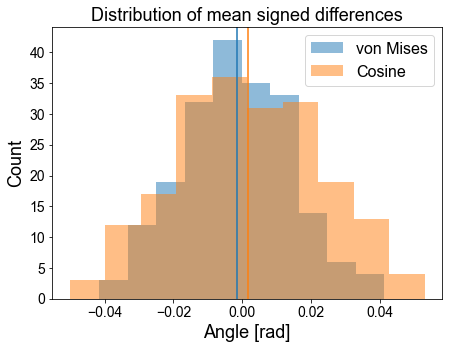

vm mean -0.0014063867491020399 - std 0.016203819921131377
cos mean 0.0015809963041605612 - std 0.020684228041864528


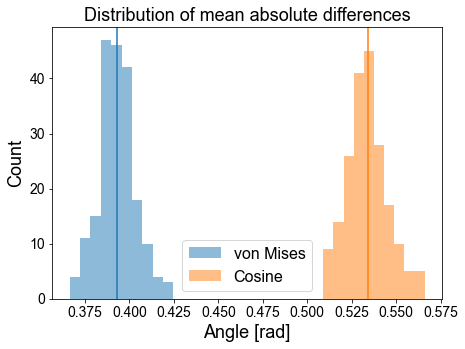

vm mean 0.39305569619656544 - std 0.010147387150185247
cos mean 0.5339132235208164 - std 0.01130739865289429


In [53]:
plt.figure(figsize=(7,5))
plt.hist(vm_means, label='von Mises', alpha=0.5, color='tab:blue')
plt.hist(cos_means, label='Cosine', alpha=0.5, color='tab:orange')
plt.axvline(np.mean(vm_results), color='tab:blue')
plt.axvline(np.mean(cos_results),  color='tab:orange')
plt.xlabel('Angle [rad]', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.legend(fontsize=16)
plt.title('Distribution of mean signed differences', fontsize=18)
# plt.tight_layout()
plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/heading_signed_diff.pdf'),
            bbox_inches='tight')


plt.show()
print(f'vm mean {np.mean(vm_means)} - std {np.std(vm_means)}')
print(f'cos mean {np.mean(cos_means)} - std {np.std(cos_means)}')


plt.figure(figsize=(7,5))
plt.hist(vm_abs_means, label='von Mises', alpha=0.5, color='tab:blue')
plt.hist(cos_abs_means, label='Cosine', alpha=0.5, color='tab:orange')
plt.axvline(np.mean(vm_abs_means), color='tab:blue')
plt.axvline(np.mean(cos_abs_means), color='tab:orange')
plt.xlabel('Angle [rad]', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.legend(fontsize=16)
plt.title('Distribution of mean absolute differences', fontsize=18)
# plt.tight_layout()
plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/heading_absolute_diff.pdf'),
            bbox_inches='tight')
plt.show()

print(f'vm mean {np.mean(vm_abs_means)} - std {np.std(vm_abs_means)}')
print(f'cos mean {np.mean(cos_abs_means)} - std {np.std(cos_abs_means)}')

In [97]:
def plot_three_paths(hs, vms, coss, path, figsize=(8,8), save=False):
    real_bee_coords = cx_spiking.plotting.compute_real_path(hs[path])
    plt.figure(figsize=(10,10))
    plt.text(0, 0, 'N', fontsize=12, fontweight='heavy', color='k', ha='center', va='center')
    plt.plot(vms[path][:T_outbound,0], vms[path][:T_outbound,1], color='red', lw=1, label='von Mises')
    plt.plot(coss[path][:T_outbound,0], coss[path][:T_outbound,1], color='green', lw=1, label='Cosine')
    plt.plot(real_bee_coords[:T_outbound,0], real_bee_coords[:T_outbound,1], color='blue', lw=1, label='Real')
    plt.legend(fontsize=20)
    plt.xlabel('Distance [steps]', fontsize=22)
    plt.ylabel('Distance [steps]', fontsize=22)
    plt.axis('scaled')
#     plt.tight_layout()
    if save:
        plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/dissertation_plots/paths/path_{path}.pdf'), bbox_inches = "tight")
    plt.show()


#     plt.figure(figsize=figsize)
#     plt.text(0, 0, 'N', fontsize=12, fontweight='heavy', color='k', ha='center', va='center')
#     plt.plot(bee_coords[:T_outbound,0], bee_coords[:T_outbound,1], color='purple', lw=1, label='Outbound')
#     if T_outbound:
#         plt.plot(bee_coords[T_outbound:,0], bee_coords[T_outbound:,1], color='green', lw=1, label='Return')
#     plt.legend()
#     plt.axis('scaled')
#     plt.show()


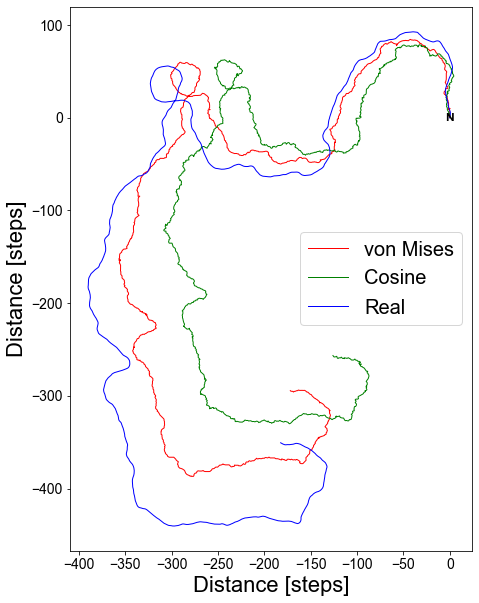

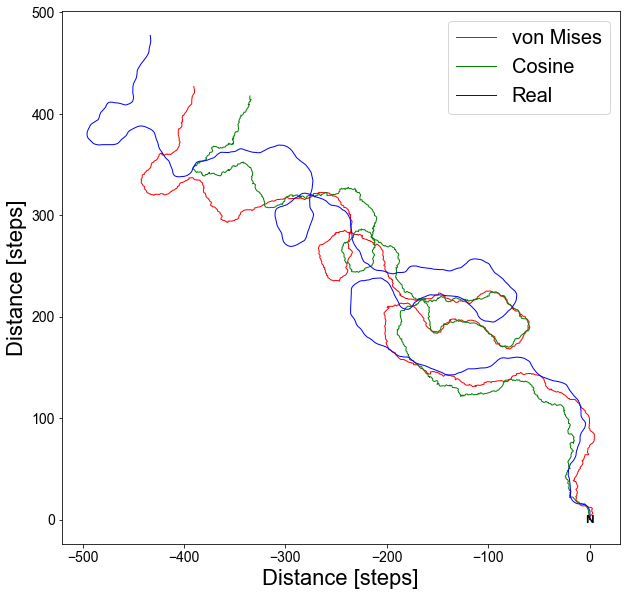

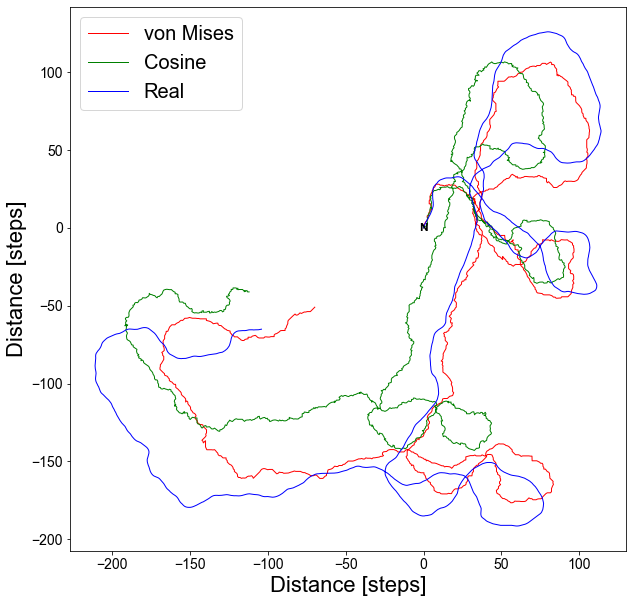

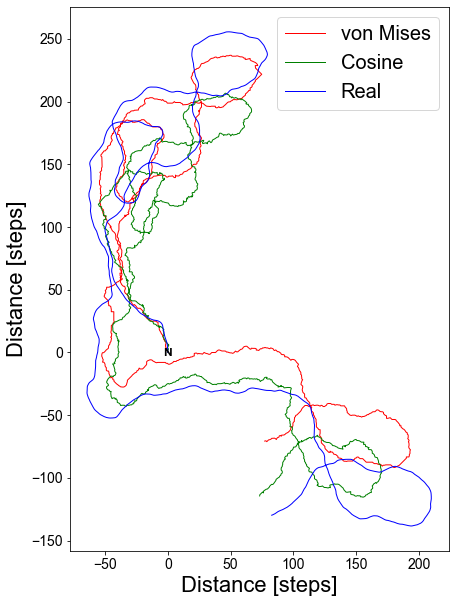

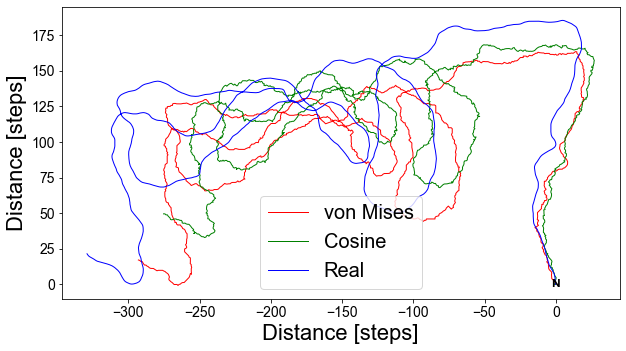

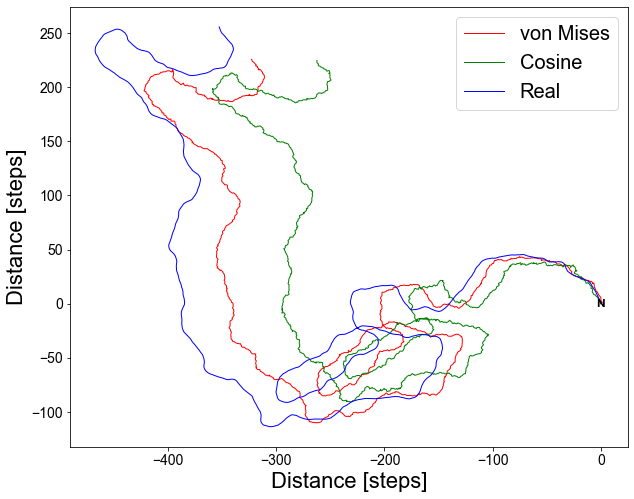

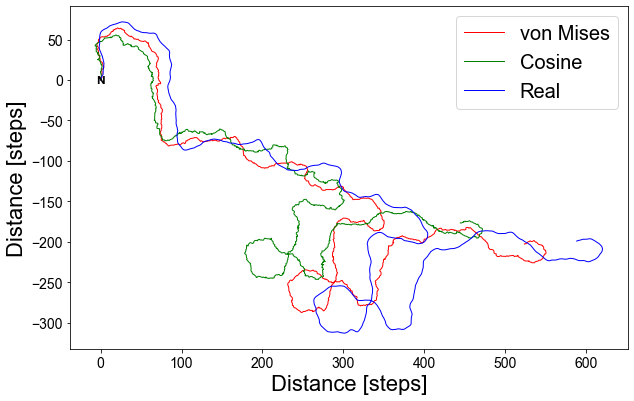

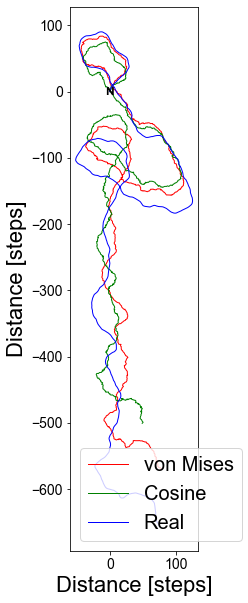

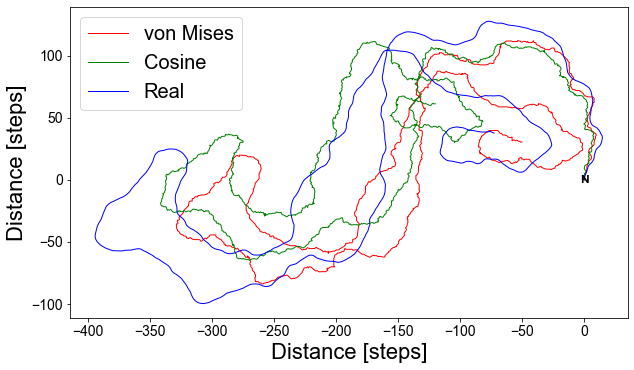

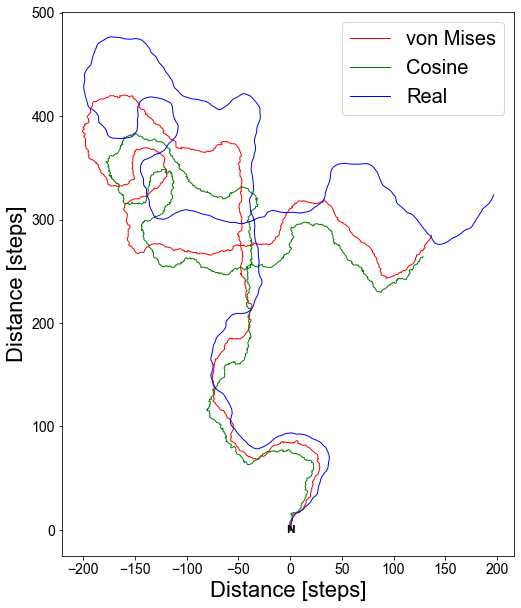

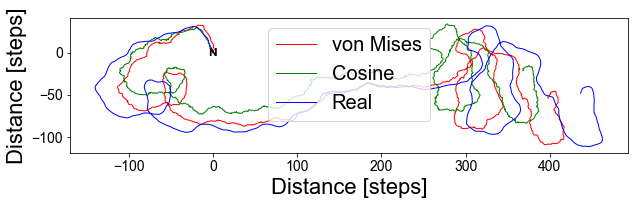

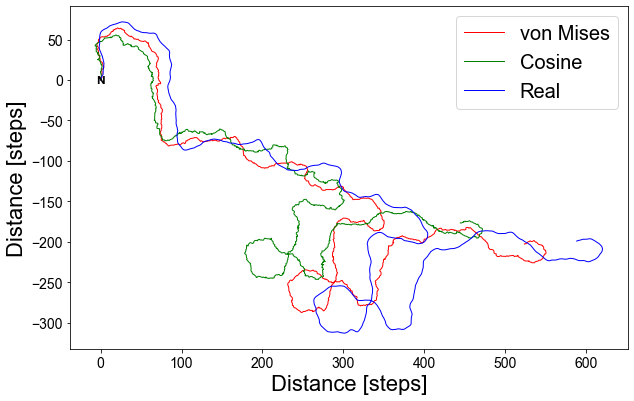

In [101]:
for i in range(11):
    plot_three_paths(hs, vm_bee_coords, cos_bee_coords, i, save=True)
plot_three_paths(hs, vm_bee_coords, cos_bee_coords, 6, save=True)

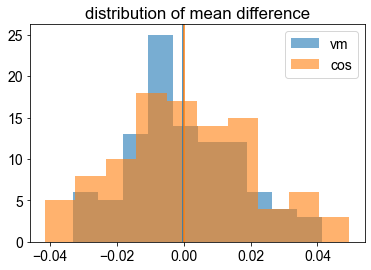

vm mean -7.938348835566353e-05 - std 0.5187709203062376
cos mean 0.00019001163442976628 - std 0.6858773568438673


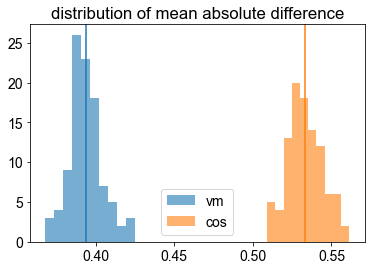

vm mean 0.3936089223458874 - std 0.010556878636185945
cos mean 0.5331504208066099 - std 0.011041777969824454


In [5]:
plot_results(cpu4_method=1)

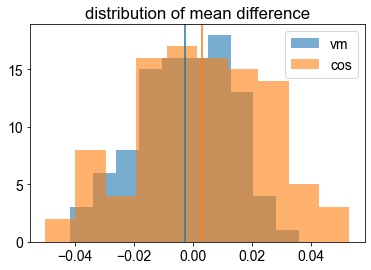

vm mean -0.002733390009848416 - std 0.5166044935491678
cos mean 0.002971980973891357 - std 0.6891647384428473


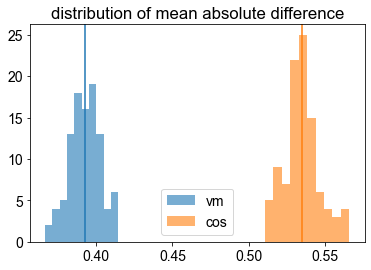

vm mean 0.3925024700472434 - std 0.009689124164120452
cos mean 0.5346760262350227 - std 0.011516506931116267


In [6]:
plot_results(cpu4_method=2)

In [102]:
cpu4_method=1
for exp in range(1):
    with open(os.path.join(routes_path, f'route_{exp}.pickle'), 'rb') as fh:
        data = pickle.load(fh)

    h = data['h']
    v = data['v']
    cx_log = data['cx_log']

    with open(os.path.join(experiments_path, f'exp_{exp}_cpu4_{cpu4_method}.pickle'), 'rb') as fh:
        data = pickle.load(fh)

    spiking_cx_vm = data['spiking_cx_vm']
    spiking_cx_cos = data['spiking_cx_cos']


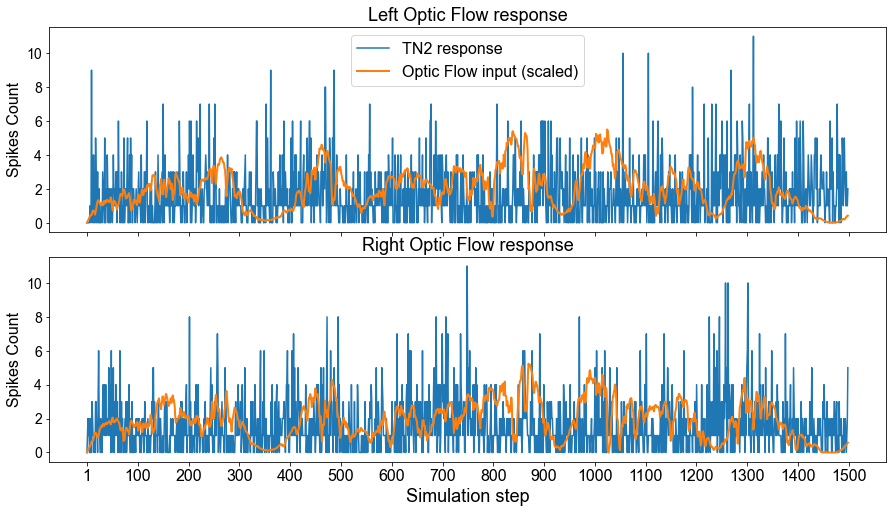

In [175]:
def get_spikes_rates(times, iss, N, T_outbound, time_step):
    spikes_t = times
    spikes_i = iss
    
    spikes_out = np.zeros((N, T_outbound))
    bins = np.arange(0, (T_outbound+1)*time_step, time_step)
    
    for i in range(N):
        spikes = spikes_t[spikes_i == i]
        spikes_count, _ = np.histogram(spikes, bins=bins)
        spikes_out[i,:] = spikes_count

    return spikes_out


# velocities = get_spikes_rates(spiking_cx_vm['SPM_TN2']['t'], spiking_cx_vm['SPM_TN2']['i'], 
#                               N_TN2, T_outbound, 0.020)
# plt.plot(spiking_cx_vm['SPM_TN2']['t'], spiking_cx_vm['SPM_TN2']['i'], '.')
# plt.xlim([0,2])
# plt.show()

fontsize=18

fig, ax = plt.subplots(2, figsize=(15,8), sharex=True, gridspec_kw={'hspace': 0.12})

ax[0].plot(velocities[0,:].T, label='TN2 response')
# ax[0].plot(scipy.signal.medfilt(velocities[0,:].T, 5), label='TN2 response(smoothed)')
ax[0].plot(cx_spiking.inputs.compute_flow(h[:T_outbound],v[:T_outbound], vmin=0, vmax=velocities.max()/2, baseline=0)[:,0], 
           label='Optic Flow input (scaled)', lw = 2)
ax[0].set_title('Left Optic Flow response', fontsize=fontsize)
ax[0].set_ylabel('Spikes Count', fontsize=fontsize-2)
ax[0].legend(fontsize=fontsize-2)

ax[1].plot(velocities[1,:].T, label='TN2 response')
# ax[1].plot(scipy.signal.medfilt(velocities[1,:].T, 5), label='TN2 response(smoothed)')
ax[1].plot(cx_spiking.inputs.compute_flow(h[:T_outbound],v[:T_outbound], vmin=0, vmax=velocities.max()/2, baseline=0)[:,1], 
           label='Optic flow input (scaled)', lw = 2)
ax[1].set_ylabel('Spikes Count', fontsize=fontsize-2)
ax[1].set_xticks(np.arange(0, T_outbound+1, 100) + 0.5)
ax[1].set_xticklabels([1,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500], fontsize=fontsize-2)
ax[1].set_xlabel('Simulation step', fontsize=fontsize)
ax[1].set_title('Right Optic Flow response', fontsize=fontsize)
plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/dissertation_plots/decoded_optic_flow.pdf'), bbox_inches = "tight")
plt.show()

In [141]:
vms = []
coss = []
vels = []
for cpu4_method in [1,2]:
    for exp in range(100):
        with open(os.path.join(routes_path, f'route_{exp}.pickle'), 'rb') as fh:
            data = pickle.load(fh)

        h = data['h']
        v = data['v']
        cx_log = data['cx_log']

        with open(os.path.join(experiments_path, f'exp_{exp}_cpu4_{cpu4_method}.pickle'), 'rb') as fh:
            data = pickle.load(fh)

        spiking_cx_vm = data['spiking_cx_vm']
        spiking_cx_cos = data['spiking_cx_cos']

        velocities_vm = get_spikes_rates(spiking_cx_vm['SPM_TN2']['t'], spiking_cx_vm['SPM_TN2']['i'], 
                                      N_TN2, T_outbound, 0.020)
        velocities_cos = get_spikes_rates(spiking_cx_cos['SPM_TN2']['t'], spiking_cx_cos['SPM_TN2']['i'], 
                                      N_TN2, T_outbound, 0.020)

        vms.append(velocities_vm)
        coss.append(velocities_cos)
        vels.append(cx_spiking.inputs.compute_flow(h[:T_outbound],v[:T_outbound], vmin=0, vmax=1, baseline=0))

In [185]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """ 
     
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
        

    if window_len<3:
        return x
    
    
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    

    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')
    
    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y    


left = []
right = []

for i in range(len(vels)):
    vm = vms[i]
    cos = coss[i]
    vel = vels[i]
    
    vm_l = scipy.signal.medfilt(vm[0,:].T, 5)
    vm_r = scipy.signal.medfilt(vm[1,:].T, 5)
    cos_l = scipy.signal.medfilt(cos[0,:].T, 5)
    cos_r = scipy.signal.medfilt(cos[1,:].T, 5)
    
#     vm_l = smooth(vm[0,:].T, 5)
#     vm_r = smooth(vm[1,:].T,5)
#     cos_l = smooth(cos[0,:].T,5)
#     cos_r = smooth(cos[1,:].T,5)
#     vm_l = vm[0,:].T
#     vm_r = vm[1,:].T
#     cos_l = cos[0,:].T
#     cos_r = cos[1,:].T

    vel_l = vel[:,0]
    vel_r = vel[:,1]

    left.append(scipy.stats.pearsonr(vm_l, vel_l)[0])
    left.append(scipy.stats.pearsonr(cos_l, vel_l)[0])
    right.append(scipy.stats.pearsonr(vm_r, vel_r)[0])
    right.append(scipy.stats.pearsonr(cos_r, vel_r)[0])

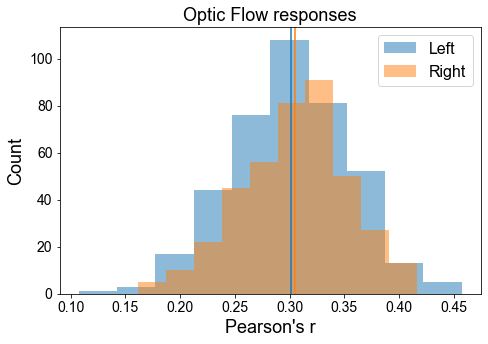

0.3010960870771255
0.30486673500272415


In [186]:
# plt.hist(left)
# # plt.show()
# plt.hist(right)
# plt.show()

plt.figure(figsize=(7,5))
plt.hist(left, label='Left', alpha=0.5, color='tab:blue')
plt.hist(right, label='Right', alpha=0.5, color='tab:orange')
plt.axvline(np.mean(left), color='tab:blue')
plt.axvline(np.mean(right),  color='tab:orange')
plt.xlabel('Pearson\'s r', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.legend(fontsize=16)
plt.title('Optic Flow responses', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/optic_flow_correlation.pdf'),
             bbox_inches='tight')


plt.show()

print(np.mean(left))
print(np.mean(right))

In [140]:
vl = velocities[0,:].T /  velocities[0,:].max()
vr = velocities[1,:].T
tl = cx_spiking.inputs.compute_flow(h[:T_outbound],v[:T_outbound], vmin=0, vmax=1, baseline=0)[:,0]
tr = cx_spiking.inputs.compute_flow(h[:T_outbound],v[:T_outbound], vmin=0, vmax=1, baseline=0)[:,1]

print(scipy.stats.pearsonr(vl, tl))

print(np.cov(vl, tl))

print(np.correlate(vl, tl))

print(scipy.stats.spearmanr(vl, tl))

(0.17047822853184397, 3.015867589927057e-11)
[[0.02355967 0.00572767]
 [0.00572767 0.04791249]]
[93.28160381]
SpearmanrResult(correlation=0.17207241946872306, pvalue=1.9612432046326304e-11)


In [106]:
speed = np.linalg.norm(velocities[:,:T_outbound], axis=0)
speed2 = np.linalg.norm(v[:T_outbound,:].T, axis=0)

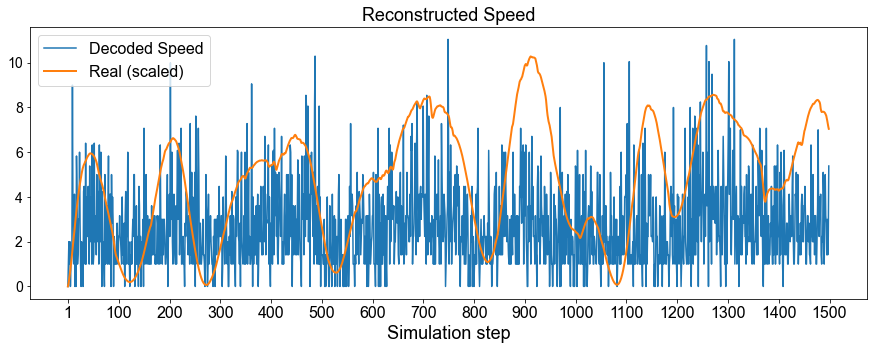

In [196]:
plt.figure(figsize=(15,5))
plt.plot(speed, alpha=1, label='Decoded Speed')
plt.plot(speed2*(speed.max()), lw=2, label='Real (scaled)')
plt.title('Reconstructed Speed', fontsize=fontsize)
plt.xticks(np.arange(0, T_outbound+1, 100) + 0.5, [1,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500], fontsize=fontsize-2)
plt.legend(fontsize=fontsize-2)
plt.xlabel('Simulation step', fontsize=fontsize)

plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/speed_decoded.pdf'),
             bbox_inches='tight')
plt.show()

In [102]:
velocities.shape

(2, 1500)

In [ ]:
*scipy.signal.medfilt(speed, 5